# Experiments with GalSim and SExtractor, Part 1

## Generate images with GalSim

The GalSim library is available from https://github.com/GalSim-developers/GalSim.

In [1]:
# experiments/galsim_helper.py contains our functions for interacting with GalSim
import galsim_helper

In [2]:
def three_sources_two_overlap(test_case):
    test_case.add_star().offset_arcsec(-5, 5)
    (test_case.add_galaxy()
         .offset_arcsec(2, 5)
         .gal_angle_deg(35)
         .axis_ratio(0.2)
    )
    test_case.add_star().offset_arcsec(10, -10)
    test_case.include_noise = True

In [3]:
galsim_helper.generate_fits_file("three_sources_two_overlap", [three_sources_two_overlap, ])

Wrote multi-extension FITS file to /home/jeff/git/Celeste/experiments/three_sources_two_overlap.fits


## Aperture photometry with SExtractor

In [4]:
# sep is a Python interface to the code SExtractor libraries.
# See https://sep.readthedocs.io/ for documentation.
import sep

In [5]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

In [6]:
# read image into standard 2-d numpy array
hdul = fits.open("three_sources_two_overlap.fits")

In [7]:
data = hdul[2].data
data = data.byteswap().newbyteorder()

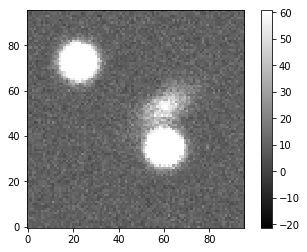

In [23]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [9]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

In [10]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

9.50293254852295
3.4107837677001953


In [11]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

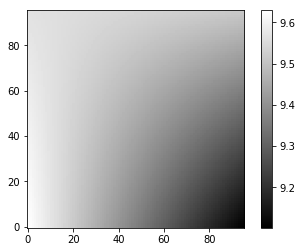

In [12]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [13]:
# subtract the background
data_sub = data - bkg

In [14]:
objs = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [15]:
# how many objects were detected
len(objs)

3

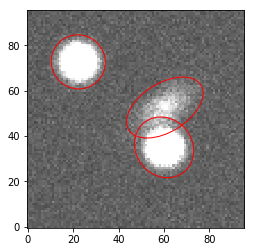

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objs)):
    e = Ellipse(xy=(objs['x'][i], objs['y'][i]),
                width=6*objs['a'][i],
                height=6*objs['b'][i],
                angle=objs['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [17]:
nelecs_per_nmgy = hdul[2].header["CLIOTA"]

In [18]:
data_sub.sum() / nelecs_per_nmgy

94.959390624999997

In [19]:
kronrad, krflag = sep.kron_radius(data, objs['x'], objs['y'], objs['a'], objs['b'], objs['theta'], 6.0)
flux, fluxerr, flag = sep.sum_ellipse(data, objs['x'], objs['y'], objs['a'], objs['b'], objs['theta'],
                                      kronrad, subpix=1)

flux_nmgy = flux / nelecs_per_nmgy
fluxerr_nmgy = fluxerr / nelecs_per_nmgy

for i in range(len(objs)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux_nmgy[i], fluxerr_nmgy[i]))

object 0: flux = 42.844548 +/- 0.000000
object 1: flux = 31.110313 +/- 0.000000
object 2: flux = 37.638793 +/- 0.000000


In [20]:
kronrad, krflag = sep.kron_radius(data, objs['x'], objs['y'], objs['a'], objs['b'], objs['theta'], 4.5)
flux, fluxerr, flag = sep.sum_ellipse(data, objs['x'], objs['y'], objs['a'], objs['b'], objs['theta'],
                                      kronrad, subpix=1)

flux_nmgy = flux / nelecs_per_nmgy
fluxerr_nmgy = fluxerr / nelecs_per_nmgy

for i in range(len(objs)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux_nmgy[i], fluxerr_nmgy[i]))

object 0: flux = 36.002454 +/- 0.000000
object 1: flux = 18.595226 +/- 0.000000
object 2: flux = 30.164460 +/- 0.000000
